# Exploring dimensionless numbers and Neural Network Regression
Author: Payam Mousavi  
Last updated: December 27, 2023 

Given the analytical equation (fitted empirically) for the Drag Coefficient $C_D$ provided in reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf, we see that it's only a function of the Reynolds number, $Re = \rho.U.D/\mu$. Let's say that we did not know this ahead of time and wanted to perform experiments for a range of input parameters, namely, $\rho$, $U$, $D$, and $\mu$. Clearly, many combinations will be redundant since they correpond to the same $Re$. Consider the following models:  

Given $\rho$, $U$, $D$, and $\mu$, consider the following two models:  



<img src="./Figures/Model_I.png" width="300" height="200" /> . 
<img src="./Figures/Model_II.png" width="300" height="200" /> . 

We are interested in the following questions:  
1. Assuming we keep the number of trainable parameters approximately the same, is Model_I more data efficient than Model_II, if we randomly sample the 4 parameters?  Intuitively, we expect this to be true since we are biasing the structure of the neural network to discover the existence of an effective compression of the inputs (by $Re$).  
2. After training Model_I, does the single node actually correspond to $Re$? Can the model 'discover' the non-dimensional parameters?  If not, can we somehow help the model to discover this?  
3. (Optional) can we use the knowledge of the $Re$ to perform data augmentation thereby increasing the efficiency of the training? For example, given a combination of inputs, we could generate $n$ additional training samples corresponding to the same $Re$. This 'synthetic data' is expected to improve the efficiency. It is not clear whether this is useful in practice. Still interesting to explore.  





In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

matplotlib.rcParams.update({'font.size': 22})
eps = 1e-12

In [2]:
def CD_calc(Re=None, U=None, D=None, rho=None, mu=None):
    """
    Calculates the the Drag coefficient (CD) and the corresponding Drag force (FD), using the empirical equation found in the
    reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf

    Use SI units

    """
    if Re is None:
        Re = rho*U*D/mu

    CD = (24/Re) \
        + ((2.6*(Re/5.)) / (1+(Re/5.)**1.52)) \
        + ((0.411*(Re/2.63e5)**-7.94) / (1 + (Re/2.63e5)**-8.)) \
        + ((0.25*(Re/1e6)) / (1 + (Re/1e6)))

    # Calculate FD if U and D and rho are given:
    if U is not None:
        FD = CD * (rho*np.pi/8) * (U**2) * (D**2)
    else:
        FD = None

    return CD, FD


def run_experiments(Re_vec, velocities=None, diameters=None, densities=None, viscosities=None):
    """
    Runs the experiment by iterating over the velocity vector or Re_vec and returning the drag coefficient CD and Drag force FD

    """
    if Re_vec is not None:
        CDs, FDs = CD_calc(Re=Re_vec, rho=None, mu=None, U=None, D=None)
    else:
        CDs, FDs = CD_calc(Re=None, U=velocities, D=diameters, rho=densities, mu=viscosities)

    return CDs, FDs


def plot_CD(Re, CD, marker='o'):
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=Re, y=CD, color='blue', marker=marker, alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-1, 1e11)
    plt.ylim(1e-2, 1e3)
    plt.xlabel('$Re$')
    plt.ylabel('$C_D$')

    return True

True

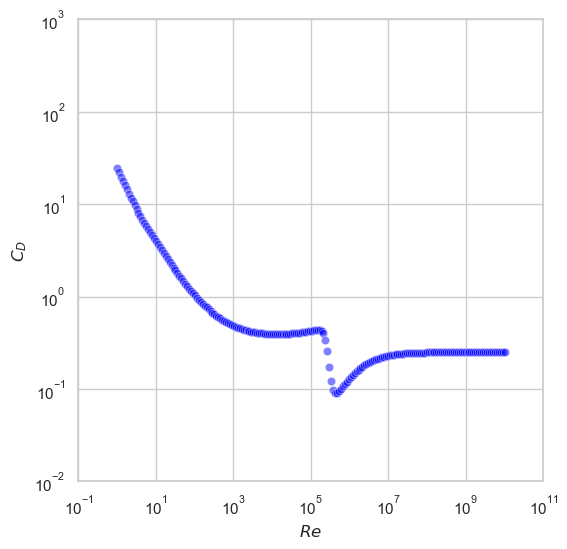

In [3]:
Re_vec = np.logspace(0, 10, 200)
CDs, _ = run_experiments(Re_vec=Re_vec)
plot_CD(Re_vec, CDs, marker='o')

## Models

In [4]:
# Model_II
class Model_II(nn.Module):
    def __init__(self, input_dim=4 , output_dim= 1, hidden_dims=[16, 8, 4]):
        super(Model_II, self).__init__()
        hidden_dims.insert(0, input_dim)
        hidden_dims.append(output_dim)
        self.layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = torch.relu(self.layers[i](x))
        x = self.layers[-1](x)  # Apply the last layer without ReLU
        return x

## Dataset Creation

In [5]:
# Data Generation:
# Let's first generate random samples of rho, mu, D, and U. The true label is then calculated using the run_experiments function. 
# The Reynolds numbers are also calculated and returned as a vector for convenience.
def sample_parameters(num_samples=5000, rho_range=[100, 2000], mu_range=[0.001, 0.01], D_range=[0.05, 0.5], U_range=[0.1, 20], seed=123):
    if seed is not None:
        np.random.seed(seed)
        
    rho = np.random.uniform(rho_range[0], rho_range[1], num_samples)
    mu = np.random.uniform(mu_range[0], mu_range[1], num_samples)
    D = np.random.uniform(D_range[0], D_range[1], num_samples)
    U = np.random.uniform(U_range[0], U_range[1], num_samples)

    # Calculate the true CD and FD:
    CD, _ = run_experiments(Re_vec=None, velocities=U, diameters=D, densities=rho, viscosities=mu)
    Re_vec = rho * U * D / mu
    return rho, mu, D, U, Re_vec, CD

class RandomDataset(Dataset):
    def __init__(self, num_samples=5000, rho_range=[100, 2000], mu_range=[0.001, 0.01], D_range=[0.05, 0.5], U_range=[0.1, 20], seed=None):
        self.rho, self.mu, self.D, self.U, self.Re, self.CD = sample_parameters(num_samples=num_samples, rho_range=rho_range, mu_range=mu_range, D_range=D_range, U_range=U_range, seed=seed)
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        input_sample = np.array([self.rho[idx], self.mu[idx], self.D[idx], self.U[idx]], dtype=np.float32)
        target = np.array([self.CD[idx]], dtype=np.float32)
        return input_sample, target


# Create the dataloader/dataset:
dataset = RandomDataset(num_samples=5000, rho_range=[100, 2000], mu_range=[0.001, 0.01], D_range=[0.05, 0.5], U_range=[0.1, 20], seed=123)

# Split the dataset into train, validation, and test sets:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0) #TODO: Change num_workers to 4. Need to take RandomDataset out of the main function
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)


# Training

In [7]:
model = Model_II(input_dim=4, output_dim=1, hidden_dims=[16, 8, 4])
model = model.float()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
writer = SummaryWriter('runs/Model_II')

NUM_EPOCHS = 500

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Training]'):
        inputs, targets = inputs.float(), targets.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    writer.add_scalar('Loss/Train', train_loss, epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Validation]'):
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    writer.add_scalar('Loss/Validation', val_loss, epoch)

    tqdm.write(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    # print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Test loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
writer.add_scalar('Loss/Test', test_loss, NUM_EPOCHS)

print(f'Final Test Loss: {test_loss:.4f}')
writer.close()

Epoch 1/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2094.01it/s]


Epoch 1/500, Train Loss: 5.2523, Validation Loss: 0.0856


Epoch 2/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2520.05it/s]


Epoch 2/500, Train Loss: 0.0850, Validation Loss: 0.0842


Epoch 3/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2408.96it/s]


Epoch 3/500, Train Loss: 0.0811, Validation Loss: 0.0828


Epoch 4/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2549.83it/s]


Epoch 4/500, Train Loss: 0.0796, Validation Loss: 0.0812


Epoch 5/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2590.28it/s]


Epoch 5/500, Train Loss: 0.0779, Validation Loss: 0.0793


Epoch 6/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2735.56it/s]


Epoch 6/500, Train Loss: 0.0760, Validation Loss: 0.0773


Epoch 7/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2306.78it/s]


Epoch 7/500, Train Loss: 0.0740, Validation Loss: 0.0752


Epoch 8/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2463.43it/s]


Epoch 8/500, Train Loss: 0.0719, Validation Loss: 0.0729


Epoch 9/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2361.66it/s]


Epoch 9/500, Train Loss: 0.0697, Validation Loss: 0.0706


Epoch 10/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2223.47it/s]


Epoch 10/500, Train Loss: 0.0674, Validation Loss: 0.0682


Epoch 11/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2603.74it/s]


Epoch 11/500, Train Loss: 0.0651, Validation Loss: 0.0659


Epoch 12/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2089.58it/s]


Epoch 12/500, Train Loss: 0.0628, Validation Loss: 0.0635


Epoch 13/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2432.71it/s]


Epoch 13/500, Train Loss: 0.0604, Validation Loss: 0.0610


Epoch 14/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2557.11it/s]


Epoch 14/500, Train Loss: 0.0581, Validation Loss: 0.0586


Epoch 15/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2348.85it/s]


Epoch 15/500, Train Loss: 0.0557, Validation Loss: 0.0563


Epoch 16/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2685.86it/s]


Epoch 16/500, Train Loss: 0.0534, Validation Loss: 0.0539


Epoch 17/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2288.30it/s]


Epoch 17/500, Train Loss: 0.0512, Validation Loss: 0.0516


Epoch 18/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2390.94it/s]


Epoch 18/500, Train Loss: 0.0489, Validation Loss: 0.0493


Epoch 19/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2167.39it/s]


Epoch 19/500, Train Loss: 0.0468, Validation Loss: 0.0471


Epoch 20/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2380.59it/s]


Epoch 20/500, Train Loss: 0.0447, Validation Loss: 0.0450


Epoch 21/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2164.80it/s]


Epoch 21/500, Train Loss: 0.0428, Validation Loss: 0.0430


Epoch 22/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2187.31it/s]


Epoch 22/500, Train Loss: 0.0408, Validation Loss: 0.0410


Epoch 23/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2549.73it/s]


Epoch 23/500, Train Loss: 0.0389, Validation Loss: 0.0391


Epoch 24/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2425.33it/s]


Epoch 24/500, Train Loss: 0.0371, Validation Loss: 0.0373


Epoch 25/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2724.90it/s]


Epoch 25/500, Train Loss: 0.0354, Validation Loss: 0.0356


Epoch 26/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2412.95it/s]


Epoch 26/500, Train Loss: 0.0338, Validation Loss: 0.0339


Epoch 27/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2602.53it/s]


Epoch 27/500, Train Loss: 0.0323, Validation Loss: 0.0326


Epoch 28/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2316.18it/s]


Epoch 28/500, Train Loss: 0.0309, Validation Loss: 0.0311


Epoch 29/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2502.29it/s]


Epoch 29/500, Train Loss: 0.0294, Validation Loss: 0.0296


Epoch 30/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2206.29it/s]


Epoch 30/500, Train Loss: 0.0282, Validation Loss: 0.0283


Epoch 31/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2613.07it/s]


Epoch 31/500, Train Loss: 0.0270, Validation Loss: 0.0272


Epoch 32/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2028.99it/s]


Epoch 32/500, Train Loss: 0.0260, Validation Loss: 0.0261


Epoch 33/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2235.55it/s]


Epoch 33/500, Train Loss: 0.0249, Validation Loss: 0.0250


Epoch 34/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2433.16it/s]


Epoch 34/500, Train Loss: 0.0240, Validation Loss: 0.0241


Epoch 35/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2344.66it/s]


Epoch 35/500, Train Loss: 0.0232, Validation Loss: 0.0233


Epoch 36/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2684.14it/s]


Epoch 36/500, Train Loss: 0.0224, Validation Loss: 0.0225


Epoch 37/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2555.07it/s]


Epoch 37/500, Train Loss: 0.0217, Validation Loss: 0.0219


Epoch 38/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2192.38it/s]


Epoch 38/500, Train Loss: 0.0211, Validation Loss: 0.0211


Epoch 39/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2554.29it/s]


Epoch 39/500, Train Loss: 0.0204, Validation Loss: 0.0205


Epoch 40/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2277.97it/s]


Epoch 40/500, Train Loss: 0.0199, Validation Loss: 0.0200


Epoch 41/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2568.66it/s]


Epoch 41/500, Train Loss: 0.0194, Validation Loss: 0.0195


Epoch 42/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2280.83it/s]


Epoch 42/500, Train Loss: 0.0190, Validation Loss: 0.0191


Epoch 43/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2173.07it/s]


Epoch 43/500, Train Loss: 0.0187, Validation Loss: 0.0188


Epoch 44/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2113.53it/s]


Epoch 44/500, Train Loss: 0.0184, Validation Loss: 0.0184


Epoch 45/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2400.60it/s]


Epoch 45/500, Train Loss: 0.0181, Validation Loss: 0.0181


Epoch 46/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2664.95it/s]


Epoch 46/500, Train Loss: 0.0178, Validation Loss: 0.0180


Epoch 47/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2460.81it/s]


Epoch 47/500, Train Loss: 0.0176, Validation Loss: 0.0176


Epoch 48/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2602.53it/s]


Epoch 48/500, Train Loss: 0.0174, Validation Loss: 0.0174


Epoch 49/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2217.60it/s]


Epoch 49/500, Train Loss: 0.0172, Validation Loss: 0.0172


Epoch 50/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2508.65it/s]


Epoch 50/500, Train Loss: 0.0170, Validation Loss: 0.0172


Epoch 51/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2257.05it/s]


Epoch 51/500, Train Loss: 0.0170, Validation Loss: 0.0169


Epoch 52/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2427.61it/s]


Epoch 52/500, Train Loss: 0.0168, Validation Loss: 0.0169


Epoch 53/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2046.81it/s]


Epoch 53/500, Train Loss: 0.0167, Validation Loss: 0.0169


Epoch 54/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2496.15it/s]


Epoch 54/500, Train Loss: 0.0167, Validation Loss: 0.0166


Epoch 55/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2117.27it/s]


Epoch 55/500, Train Loss: 0.0166, Validation Loss: 0.0166


Epoch 56/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2066.41it/s]


Epoch 56/500, Train Loss: 0.0165, Validation Loss: 0.0166


Epoch 57/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2523.36it/s]


Epoch 57/500, Train Loss: 0.0165, Validation Loss: 0.0164


Epoch 58/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2429.46it/s]


Epoch 58/500, Train Loss: 0.0166, Validation Loss: 0.0164


Epoch 59/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2536.05it/s]


Epoch 59/500, Train Loss: 0.0164, Validation Loss: 0.0164


Epoch 60/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2329.52it/s]


Epoch 60/500, Train Loss: 0.0164, Validation Loss: 0.0163


Epoch 61/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2593.98it/s]


Epoch 61/500, Train Loss: 0.0164, Validation Loss: 0.0163


Epoch 62/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2407.84it/s]


Epoch 62/500, Train Loss: 0.0163, Validation Loss: 0.0163


Epoch 63/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2617.35it/s]


Epoch 63/500, Train Loss: 0.0162, Validation Loss: 0.0161


Epoch 64/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2284.09it/s]


Epoch 64/500, Train Loss: 0.0163, Validation Loss: 0.0161


Epoch 65/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2548.28it/s]


Epoch 65/500, Train Loss: 0.0162, Validation Loss: 0.0161


Epoch 66/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2365.15it/s]


Epoch 66/500, Train Loss: 0.0162, Validation Loss: 0.0162


Epoch 67/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2261.77it/s]


Epoch 67/500, Train Loss: 0.0162, Validation Loss: 0.0162


Epoch 68/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2522.32it/s]


Epoch 68/500, Train Loss: 0.0162, Validation Loss: 0.0160


Epoch 69/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2219.14it/s]


Epoch 69/500, Train Loss: 0.0164, Validation Loss: 0.0160


Epoch 70/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2658.20it/s]


Epoch 70/500, Train Loss: 0.0161, Validation Loss: 0.0161


Epoch 71/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2168.09it/s]


Epoch 71/500, Train Loss: 0.0160, Validation Loss: 0.0160


Epoch 72/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2484.87it/s]


Epoch 72/500, Train Loss: 0.0160, Validation Loss: 0.0159


Epoch 73/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2326.29it/s]


Epoch 73/500, Train Loss: 0.0161, Validation Loss: 0.0160


Epoch 74/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2470.33it/s]


Epoch 74/500, Train Loss: 0.0161, Validation Loss: 0.0158


Epoch 75/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2471.05it/s]


Epoch 75/500, Train Loss: 0.0159, Validation Loss: 0.0159


Epoch 76/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1944.34it/s]


Epoch 76/500, Train Loss: 0.0159, Validation Loss: 0.0158


Epoch 77/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2001.76it/s]


Epoch 77/500, Train Loss: 0.0160, Validation Loss: 0.0158


Epoch 78/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2212.99it/s]


Epoch 78/500, Train Loss: 0.0159, Validation Loss: 0.0163


Epoch 79/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2632.86it/s]


Epoch 79/500, Train Loss: 0.0160, Validation Loss: 0.0168


Epoch 80/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2386.26it/s]


Epoch 80/500, Train Loss: 0.0159, Validation Loss: 0.0158


Epoch 81/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2570.24it/s]


Epoch 81/500, Train Loss: 0.0159, Validation Loss: 0.0157


Epoch 82/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2287.98it/s]


Epoch 82/500, Train Loss: 0.0159, Validation Loss: 0.0157


Epoch 83/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2723.35it/s]


Epoch 83/500, Train Loss: 0.0159, Validation Loss: 0.0155


Epoch 84/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2455.86it/s]


Epoch 84/500, Train Loss: 0.0158, Validation Loss: 0.0163


Epoch 85/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2332.36it/s]


Epoch 85/500, Train Loss: 0.0158, Validation Loss: 0.0154


Epoch 86/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2318.18it/s]


Epoch 86/500, Train Loss: 0.0158, Validation Loss: 0.0154


Epoch 87/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2382.03it/s]


Epoch 87/500, Train Loss: 0.0156, Validation Loss: 0.0153


Epoch 88/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2331.06it/s]


Epoch 88/500, Train Loss: 0.0155, Validation Loss: 0.0153


Epoch 89/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2024.77it/s]


Epoch 89/500, Train Loss: 0.0154, Validation Loss: 0.0159


Epoch 90/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2276.96it/s]


Epoch 90/500, Train Loss: 0.0155, Validation Loss: 0.0151


Epoch 91/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2605.46it/s]


Epoch 91/500, Train Loss: 0.0154, Validation Loss: 0.0156


Epoch 92/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2394.52it/s]


Epoch 92/500, Train Loss: 0.0154, Validation Loss: 0.0151


Epoch 93/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2390.17it/s]


Epoch 93/500, Train Loss: 0.0152, Validation Loss: 0.0170


Epoch 94/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2422.09it/s]


Epoch 94/500, Train Loss: 0.0158, Validation Loss: 0.0149


Epoch 95/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2322.83it/s]


Epoch 95/500, Train Loss: 0.0149, Validation Loss: 0.0148


Epoch 96/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2629.86it/s]


Epoch 96/500, Train Loss: 0.0149, Validation Loss: 0.0146


Epoch 97/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2336.82it/s]


Epoch 97/500, Train Loss: 0.0149, Validation Loss: 0.0146


Epoch 98/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2654.20it/s]


Epoch 98/500, Train Loss: 0.0149, Validation Loss: 0.0155


Epoch 99/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2242.49it/s]


Epoch 99/500, Train Loss: 0.0152, Validation Loss: 0.0145


Epoch 100/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2169.84it/s]


Epoch 100/500, Train Loss: 0.0144, Validation Loss: 0.0146


Epoch 101/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2570.63it/s]


Epoch 101/500, Train Loss: 0.0144, Validation Loss: 0.0139


Epoch 102/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2378.57it/s]


Epoch 102/500, Train Loss: 0.0143, Validation Loss: 0.0136


Epoch 103/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2503.22it/s]


Epoch 103/500, Train Loss: 0.0141, Validation Loss: 0.0134


Epoch 104/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2636.27it/s]


Epoch 104/500, Train Loss: 0.0137, Validation Loss: 0.0133


Epoch 105/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2359.50it/s]


Epoch 105/500, Train Loss: 0.0137, Validation Loss: 0.0132


Epoch 106/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2625.54it/s]


Epoch 106/500, Train Loss: 0.0136, Validation Loss: 0.0130


Epoch 107/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2270.72it/s]


Epoch 107/500, Train Loss: 0.0140, Validation Loss: 0.0132


Epoch 108/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2410.78it/s]


Epoch 108/500, Train Loss: 0.0135, Validation Loss: 0.0128


Epoch 109/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2281.76it/s]


Epoch 109/500, Train Loss: 0.0134, Validation Loss: 0.0134


Epoch 110/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2363.32it/s]


Epoch 110/500, Train Loss: 0.0135, Validation Loss: 0.0136


Epoch 111/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1759.36it/s]


Epoch 111/500, Train Loss: 0.0134, Validation Loss: 0.0125


Epoch 112/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2398.54it/s]


Epoch 112/500, Train Loss: 0.0131, Validation Loss: 0.0127


Epoch 113/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2230.86it/s]


Epoch 113/500, Train Loss: 0.0130, Validation Loss: 0.0124


Epoch 114/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2447.26it/s]


Epoch 114/500, Train Loss: 0.0132, Validation Loss: 0.0124


Epoch 115/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2506.59it/s]


Epoch 115/500, Train Loss: 0.0128, Validation Loss: 0.0122


Epoch 116/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2420.95it/s]


Epoch 116/500, Train Loss: 0.0131, Validation Loss: 0.0124


Epoch 117/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2473.33it/s]


Epoch 117/500, Train Loss: 0.0129, Validation Loss: 0.0129


Epoch 118/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2347.45it/s]


Epoch 118/500, Train Loss: 0.0129, Validation Loss: 0.0122


Epoch 119/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2339.18it/s]


Epoch 119/500, Train Loss: 0.0130, Validation Loss: 0.0121


Epoch 120/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2267.96it/s]


Epoch 120/500, Train Loss: 0.0125, Validation Loss: 0.0140


Epoch 121/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2354.70it/s]


Epoch 121/500, Train Loss: 0.0135, Validation Loss: 0.0123


Epoch 122/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2544.03it/s]


Epoch 122/500, Train Loss: 0.0129, Validation Loss: 0.0122


Epoch 123/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2251.60it/s]


Epoch 123/500, Train Loss: 0.0131, Validation Loss: 0.0123


Epoch 124/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2587.38it/s]


Epoch 124/500, Train Loss: 0.0125, Validation Loss: 0.0121


Epoch 125/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2330.33it/s]


Epoch 125/500, Train Loss: 0.0127, Validation Loss: 0.0121


Epoch 126/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2438.73it/s]


Epoch 126/500, Train Loss: 0.0127, Validation Loss: 0.0130


Epoch 127/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2401.03it/s]


Epoch 127/500, Train Loss: 0.0127, Validation Loss: 0.0120


Epoch 128/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2147.41it/s]


Epoch 128/500, Train Loss: 0.0125, Validation Loss: 0.0122


Epoch 129/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2322.59it/s]


Epoch 129/500, Train Loss: 0.0128, Validation Loss: 0.0126


Epoch 130/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2640.73it/s]


Epoch 130/500, Train Loss: 0.0133, Validation Loss: 0.0125


Epoch 131/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2324.20it/s]


Epoch 131/500, Train Loss: 0.0129, Validation Loss: 0.0121


Epoch 132/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1825.89it/s]


Epoch 132/500, Train Loss: 0.0124, Validation Loss: 0.0132


Epoch 133/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2356.02it/s]


Epoch 133/500, Train Loss: 0.0128, Validation Loss: 0.0120


Epoch 134/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2388.81it/s]


Epoch 134/500, Train Loss: 0.0125, Validation Loss: 0.0158


Epoch 135/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2603.34it/s]


Epoch 135/500, Train Loss: 0.0125, Validation Loss: 0.0130


Epoch 136/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2258.65it/s]


Epoch 136/500, Train Loss: 0.0129, Validation Loss: 0.0121


Epoch 137/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2552.64it/s]


Epoch 137/500, Train Loss: 0.0127, Validation Loss: 0.0128


Epoch 138/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2211.46it/s]


Epoch 138/500, Train Loss: 0.0130, Validation Loss: 0.0143


Epoch 139/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2430.86it/s]


Epoch 139/500, Train Loss: 0.0126, Validation Loss: 0.0120


Epoch 140/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2271.03it/s]


Epoch 140/500, Train Loss: 0.0125, Validation Loss: 0.0133


Epoch 141/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2470.42it/s]


Epoch 141/500, Train Loss: 0.0125, Validation Loss: 0.0120


Epoch 142/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2415.03it/s]


Epoch 142/500, Train Loss: 0.0128, Validation Loss: 0.0120


Epoch 143/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2654.31it/s]


Epoch 143/500, Train Loss: 0.0126, Validation Loss: 0.0119


Epoch 144/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2368.91it/s]


Epoch 144/500, Train Loss: 0.0124, Validation Loss: 0.0127


Epoch 145/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2402.06it/s]


Epoch 145/500, Train Loss: 0.0130, Validation Loss: 0.0123


Epoch 146/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2348.76it/s]


Epoch 146/500, Train Loss: 0.0127, Validation Loss: 0.0120


Epoch 147/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2619.19it/s]


Epoch 147/500, Train Loss: 0.0126, Validation Loss: 0.0119


Epoch 148/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2120.95it/s]


Epoch 148/500, Train Loss: 0.0125, Validation Loss: 0.0123


Epoch 149/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2422.00it/s]


Epoch 149/500, Train Loss: 0.0124, Validation Loss: 0.0121


Epoch 150/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2560.43it/s]


Epoch 150/500, Train Loss: 0.0124, Validation Loss: 0.0119


Epoch 151/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2383.80it/s]


Epoch 151/500, Train Loss: 0.0126, Validation Loss: 0.0119


Epoch 152/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1690.48it/s]


Epoch 152/500, Train Loss: 0.0125, Validation Loss: 0.0119


Epoch 153/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2472.24it/s]


Epoch 153/500, Train Loss: 0.0131, Validation Loss: 0.0123


Epoch 154/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2244.67it/s]


Epoch 154/500, Train Loss: 0.0130, Validation Loss: 0.0137


Epoch 155/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2467.60it/s]


Epoch 155/500, Train Loss: 0.0128, Validation Loss: 0.0128


Epoch 156/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2332.27it/s]


Epoch 156/500, Train Loss: 0.0129, Validation Loss: 0.0150


Epoch 157/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2653.36it/s]


Epoch 157/500, Train Loss: 0.0126, Validation Loss: 0.0119


Epoch 158/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2326.29it/s]


Epoch 158/500, Train Loss: 0.0124, Validation Loss: 0.0124


Epoch 159/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2565.42it/s]


Epoch 159/500, Train Loss: 0.0130, Validation Loss: 0.0124


Epoch 160/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2327.58it/s]


Epoch 160/500, Train Loss: 0.0123, Validation Loss: 0.0122


Epoch 161/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2511.47it/s]


Epoch 161/500, Train Loss: 0.0127, Validation Loss: 0.0119


Epoch 162/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1820.10it/s]


Epoch 162/500, Train Loss: 0.0124, Validation Loss: 0.0121


Epoch 163/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2186.38it/s]


Epoch 163/500, Train Loss: 0.0124, Validation Loss: 0.0124


Epoch 164/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2531.55it/s]


Epoch 164/500, Train Loss: 0.0124, Validation Loss: 0.0119


Epoch 165/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2506.68it/s]


Epoch 165/500, Train Loss: 0.0123, Validation Loss: 0.0121


Epoch 166/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2392.05it/s]


Epoch 166/500, Train Loss: 0.0124, Validation Loss: 0.0118


Epoch 167/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2498.84it/s]


Epoch 167/500, Train Loss: 0.0124, Validation Loss: 0.0120


Epoch 168/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2248.81it/s]


Epoch 168/500, Train Loss: 0.0127, Validation Loss: 0.0119


Epoch 169/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2286.43it/s]


Epoch 169/500, Train Loss: 0.0125, Validation Loss: 0.0123


Epoch 170/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2573.98it/s]


Epoch 170/500, Train Loss: 0.0126, Validation Loss: 0.0119


Epoch 171/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2365.07it/s]


Epoch 171/500, Train Loss: 0.0123, Validation Loss: 0.0128


Epoch 172/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1477.91it/s]


Epoch 172/500, Train Loss: 0.0125, Validation Loss: 0.0125


Epoch 173/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2319.06it/s]


Epoch 173/500, Train Loss: 0.0125, Validation Loss: 0.0119


Epoch 174/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2140.50it/s]


Epoch 174/500, Train Loss: 0.0126, Validation Loss: 0.0124


Epoch 175/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2422.35it/s]


Epoch 175/500, Train Loss: 0.0126, Validation Loss: 0.0119


Epoch 176/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2596.99it/s]


Epoch 176/500, Train Loss: 0.0123, Validation Loss: 0.0125


Epoch 177/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2299.82it/s]


Epoch 177/500, Train Loss: 0.0125, Validation Loss: 0.0118


Epoch 178/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2296.91it/s]


Epoch 178/500, Train Loss: 0.0124, Validation Loss: 0.0118


Epoch 179/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2338.45it/s]


Epoch 179/500, Train Loss: 0.0123, Validation Loss: 0.0128


Epoch 180/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2304.17it/s]


Epoch 180/500, Train Loss: 0.0124, Validation Loss: 0.0118


Epoch 181/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2472.97it/s]


Epoch 181/500, Train Loss: 0.0124, Validation Loss: 0.0118


Epoch 182/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1967.71it/s]


Epoch 182/500, Train Loss: 0.0125, Validation Loss: 0.0121


Epoch 183/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2411.47it/s]


Epoch 183/500, Train Loss: 0.0122, Validation Loss: 0.0121


Epoch 184/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2105.84it/s]


Epoch 184/500, Train Loss: 0.0125, Validation Loss: 0.0118


Epoch 185/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2397.77it/s]


Epoch 185/500, Train Loss: 0.0124, Validation Loss: 0.0126


Epoch 186/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2548.18it/s]


Epoch 186/500, Train Loss: 0.0123, Validation Loss: 0.0118


Epoch 187/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2190.59it/s]


Epoch 187/500, Train Loss: 0.0125, Validation Loss: 0.0139


Epoch 188/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2343.35it/s]


Epoch 188/500, Train Loss: 0.0130, Validation Loss: 0.0119


Epoch 189/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2490.22it/s]


Epoch 189/500, Train Loss: 0.0125, Validation Loss: 0.0118


Epoch 190/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2154.86it/s]


Epoch 190/500, Train Loss: 0.0124, Validation Loss: 0.0122


Epoch 191/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1826.04it/s]


Epoch 191/500, Train Loss: 0.0123, Validation Loss: 0.0117


Epoch 192/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2450.21it/s]


Epoch 192/500, Train Loss: 0.0124, Validation Loss: 0.0121


Epoch 193/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2637.31it/s]


Epoch 193/500, Train Loss: 0.0123, Validation Loss: 0.0119


Epoch 194/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2302.74it/s]


Epoch 194/500, Train Loss: 0.0122, Validation Loss: 0.0126


Epoch 195/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2258.57it/s]


Epoch 195/500, Train Loss: 0.0123, Validation Loss: 0.0124


Epoch 196/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2369.33it/s]


Epoch 196/500, Train Loss: 0.0123, Validation Loss: 0.0118


Epoch 197/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2431.30it/s]


Epoch 197/500, Train Loss: 0.0128, Validation Loss: 0.0117


Epoch 198/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2478.26it/s]


Epoch 198/500, Train Loss: 0.0122, Validation Loss: 0.0140


Epoch 199/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2396.23it/s]


Epoch 199/500, Train Loss: 0.0125, Validation Loss: 0.0118


Epoch 200/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2589.98it/s]


Epoch 200/500, Train Loss: 0.0122, Validation Loss: 0.0117


Epoch 201/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2267.88it/s]


Epoch 201/500, Train Loss: 0.0123, Validation Loss: 0.0117


Epoch 202/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2497.72it/s]


Epoch 202/500, Train Loss: 0.0126, Validation Loss: 0.0120


Epoch 203/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2401.98it/s]


Epoch 203/500, Train Loss: 0.0121, Validation Loss: 0.0121


Epoch 204/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2257.73it/s]


Epoch 204/500, Train Loss: 0.0124, Validation Loss: 0.0123


Epoch 205/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2135.32it/s]


Epoch 205/500, Train Loss: 0.0123, Validation Loss: 0.0117


Epoch 206/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2491.42it/s]


Epoch 206/500, Train Loss: 0.0127, Validation Loss: 0.0121


Epoch 207/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1789.71it/s]


Epoch 207/500, Train Loss: 0.0122, Validation Loss: 0.0118


Epoch 208/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2305.43it/s]


Epoch 208/500, Train Loss: 0.0123, Validation Loss: 0.0129


Epoch 209/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2613.99it/s]


Epoch 209/500, Train Loss: 0.0127, Validation Loss: 0.0118


Epoch 210/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2347.78it/s]


Epoch 210/500, Train Loss: 0.0122, Validation Loss: 0.0116


Epoch 211/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1786.95it/s]


Epoch 211/500, Train Loss: 0.0121, Validation Loss: 0.0119


Epoch 212/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2328.23it/s]


Epoch 212/500, Train Loss: 0.0121, Validation Loss: 0.0118


Epoch 213/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2298.48it/s]


Epoch 213/500, Train Loss: 0.0124, Validation Loss: 0.0123


Epoch 214/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2442.45it/s]


Epoch 214/500, Train Loss: 0.0126, Validation Loss: 0.0134


Epoch 215/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2310.75it/s]


Epoch 215/500, Train Loss: 0.0122, Validation Loss: 0.0120


Epoch 216/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2470.96it/s]


Epoch 216/500, Train Loss: 0.0124, Validation Loss: 0.0121


Epoch 217/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2375.62it/s]


Epoch 217/500, Train Loss: 0.0122, Validation Loss: 0.0117


Epoch 218/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2368.91it/s]


Epoch 218/500, Train Loss: 0.0120, Validation Loss: 0.0118


Epoch 219/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2632.44it/s]


Epoch 219/500, Train Loss: 0.0121, Validation Loss: 0.0122


Epoch 220/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2419.47it/s]


Epoch 220/500, Train Loss: 0.0122, Validation Loss: 0.0134


Epoch 221/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2184.04it/s]


Epoch 221/500, Train Loss: 0.0125, Validation Loss: 0.0117


Epoch 222/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2358.09it/s]


Epoch 222/500, Train Loss: 0.0120, Validation Loss: 0.0120


Epoch 223/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2370.58it/s]


Epoch 223/500, Train Loss: 0.0121, Validation Loss: 0.0121


Epoch 224/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2378.40it/s]


Epoch 224/500, Train Loss: 0.0120, Validation Loss: 0.0116


Epoch 225/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2470.42it/s]


Epoch 225/500, Train Loss: 0.0119, Validation Loss: 0.0117


Epoch 226/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2332.68it/s]


Epoch 226/500, Train Loss: 0.0123, Validation Loss: 0.0120


Epoch 227/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2228.72it/s]


Epoch 227/500, Train Loss: 0.0127, Validation Loss: 0.0121


Epoch 228/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2383.38it/s]


Epoch 228/500, Train Loss: 0.0125, Validation Loss: 0.0120


Epoch 229/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2151.68it/s]


Epoch 229/500, Train Loss: 0.0122, Validation Loss: 0.0122


Epoch 230/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1225.64it/s]


Epoch 230/500, Train Loss: 0.0122, Validation Loss: 0.0115


Epoch 231/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2328.07it/s]


Epoch 231/500, Train Loss: 0.0120, Validation Loss: 0.0122


Epoch 232/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2576.06it/s]


Epoch 232/500, Train Loss: 0.0125, Validation Loss: 0.0116


Epoch 233/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2349.42it/s]


Epoch 233/500, Train Loss: 0.0120, Validation Loss: 0.0116


Epoch 234/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2424.63it/s]


Epoch 234/500, Train Loss: 0.0120, Validation Loss: 0.0121


Epoch 235/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2543.74it/s]


Epoch 235/500, Train Loss: 0.0122, Validation Loss: 0.0115


Epoch 236/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2443.17it/s]


Epoch 236/500, Train Loss: 0.0120, Validation Loss: 0.0116


Epoch 237/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2167.46it/s]


Epoch 237/500, Train Loss: 0.0119, Validation Loss: 0.0122


Epoch 238/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2416.86it/s]


Epoch 238/500, Train Loss: 0.0122, Validation Loss: 0.0134


Epoch 239/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2298.80it/s]


Epoch 239/500, Train Loss: 0.0119, Validation Loss: 0.0121


Epoch 240/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2318.18it/s]


Epoch 240/500, Train Loss: 0.0119, Validation Loss: 0.0115


Epoch 241/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2401.38it/s]


Epoch 241/500, Train Loss: 0.0117, Validation Loss: 0.0118


Epoch 242/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2273.34it/s]


Epoch 242/500, Train Loss: 0.0119, Validation Loss: 0.0117


Epoch 243/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2598.60it/s]


Epoch 243/500, Train Loss: 0.0121, Validation Loss: 0.0115


Epoch 244/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2182.19it/s]


Epoch 244/500, Train Loss: 0.0121, Validation Loss: 0.0114


Epoch 245/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2449.77it/s]


Epoch 245/500, Train Loss: 0.0119, Validation Loss: 0.0114


Epoch 246/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2203.61it/s]


Epoch 246/500, Train Loss: 0.0120, Validation Loss: 0.0114


Epoch 247/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2450.21it/s]


Epoch 247/500, Train Loss: 0.0119, Validation Loss: 0.0116


Epoch 248/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2613.07it/s]


Epoch 248/500, Train Loss: 0.0122, Validation Loss: 0.0128


Epoch 249/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2282.46it/s]


Epoch 249/500, Train Loss: 0.0119, Validation Loss: 0.0114


Epoch 250/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2567.38it/s]


Epoch 250/500, Train Loss: 0.0119, Validation Loss: 0.0115


Epoch 251/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2529.64it/s]


Epoch 251/500, Train Loss: 0.0118, Validation Loss: 0.0117


Epoch 252/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2434.66it/s]


Epoch 252/500, Train Loss: 0.0119, Validation Loss: 0.0114


Epoch 253/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2422.53it/s]


Epoch 253/500, Train Loss: 0.0117, Validation Loss: 0.0114


Epoch 254/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2246.55it/s]


Epoch 254/500, Train Loss: 0.0119, Validation Loss: 0.0119


Epoch 255/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2594.38it/s]


Epoch 255/500, Train Loss: 0.0118, Validation Loss: 0.0115


Epoch 256/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2666.12it/s]


Epoch 256/500, Train Loss: 0.0119, Validation Loss: 0.0114


Epoch 257/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2699.04it/s]


Epoch 257/500, Train Loss: 0.0117, Validation Loss: 0.0116


Epoch 258/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2569.06it/s]


Epoch 258/500, Train Loss: 0.0120, Validation Loss: 0.0128


Epoch 259/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2444.95it/s]


Epoch 259/500, Train Loss: 0.0119, Validation Loss: 0.0113


Epoch 260/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2709.61it/s]


Epoch 260/500, Train Loss: 0.0120, Validation Loss: 0.0143


Epoch 261/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2460.09it/s]


Epoch 261/500, Train Loss: 0.0118, Validation Loss: 0.0114


Epoch 262/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2642.50it/s]


Epoch 262/500, Train Loss: 0.0117, Validation Loss: 0.0113


Epoch 263/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2623.90it/s]


Epoch 263/500, Train Loss: 0.0117, Validation Loss: 0.0113


Epoch 264/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2460.72it/s]


Epoch 264/500, Train Loss: 0.0118, Validation Loss: 0.0148


Epoch 265/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2585.19it/s]


Epoch 265/500, Train Loss: 0.0121, Validation Loss: 0.0113


Epoch 266/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2613.78it/s]


Epoch 266/500, Train Loss: 0.0117, Validation Loss: 0.0112


Epoch 267/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2445.30it/s]


Epoch 267/500, Train Loss: 0.0120, Validation Loss: 0.0113


Epoch 268/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2672.49it/s]


Epoch 268/500, Train Loss: 0.0125, Validation Loss: 0.0116


Epoch 269/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2643.75it/s]


Epoch 269/500, Train Loss: 0.0120, Validation Loss: 0.0131


Epoch 270/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2701.75it/s]


Epoch 270/500, Train Loss: 0.0116, Validation Loss: 0.0114


Epoch 271/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2714.54it/s]


Epoch 271/500, Train Loss: 0.0118, Validation Loss: 0.0118


Epoch 272/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2220.60it/s]


Epoch 272/500, Train Loss: 0.0116, Validation Loss: 0.0112


Epoch 273/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2600.82it/s]


Epoch 273/500, Train Loss: 0.0119, Validation Loss: 0.0112


Epoch 274/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2480.64it/s]


Epoch 274/500, Train Loss: 0.0122, Validation Loss: 0.0122


Epoch 275/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2656.09it/s]


Epoch 275/500, Train Loss: 0.0117, Validation Loss: 0.0113


Epoch 276/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2659.57it/s]


Epoch 276/500, Train Loss: 0.0117, Validation Loss: 0.0112


Epoch 277/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2576.95it/s]


Epoch 277/500, Train Loss: 0.0118, Validation Loss: 0.0113


Epoch 278/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2694.59it/s]


Epoch 278/500, Train Loss: 0.0116, Validation Loss: 0.0112


Epoch 279/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2747.77it/s]


Epoch 279/500, Train Loss: 0.0119, Validation Loss: 0.0111


Epoch 280/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2729.44it/s]


Epoch 280/500, Train Loss: 0.0118, Validation Loss: 0.0114


Epoch 281/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2700.45it/s]


Epoch 281/500, Train Loss: 0.0115, Validation Loss: 0.0111


Epoch 282/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2629.35it/s]


Epoch 282/500, Train Loss: 0.0117, Validation Loss: 0.0112


Epoch 283/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2648.55it/s]


Epoch 283/500, Train Loss: 0.0119, Validation Loss: 0.0128


Epoch 284/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2669.41it/s]


Epoch 284/500, Train Loss: 0.0118, Validation Loss: 0.0111


Epoch 285/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2740.59it/s]


Epoch 285/500, Train Loss: 0.0116, Validation Loss: 0.0120


Epoch 286/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2729.78it/s]


Epoch 286/500, Train Loss: 0.0120, Validation Loss: 0.0113


Epoch 287/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2493.73it/s]


Epoch 287/500, Train Loss: 0.0116, Validation Loss: 0.0119


Epoch 288/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2597.49it/s]


Epoch 288/500, Train Loss: 0.0119, Validation Loss: 0.0117


Epoch 289/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2539.31it/s]


Epoch 289/500, Train Loss: 0.0115, Validation Loss: 0.0114


Epoch 290/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2491.88it/s]


Epoch 290/500, Train Loss: 0.0117, Validation Loss: 0.0111


Epoch 291/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2261.84it/s]


Epoch 291/500, Train Loss: 0.0116, Validation Loss: 0.0113


Epoch 292/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2717.84it/s]


Epoch 292/500, Train Loss: 0.0113, Validation Loss: 0.0113


Epoch 293/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2446.46it/s]


Epoch 293/500, Train Loss: 0.0114, Validation Loss: 0.0113


Epoch 294/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2550.21it/s]


Epoch 294/500, Train Loss: 0.0116, Validation Loss: 0.0116


Epoch 295/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2696.22it/s]


Epoch 295/500, Train Loss: 0.0113, Validation Loss: 0.0110


Epoch 296/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2725.79it/s]


Epoch 296/500, Train Loss: 0.0114, Validation Loss: 0.0111


Epoch 297/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2391.96it/s]


Epoch 297/500, Train Loss: 0.0116, Validation Loss: 0.0115


Epoch 298/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2601.52it/s]


Epoch 298/500, Train Loss: 0.0116, Validation Loss: 0.0118


Epoch 299/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2454.78it/s]


Epoch 299/500, Train Loss: 0.0115, Validation Loss: 0.0111


Epoch 300/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2700.78it/s]


Epoch 300/500, Train Loss: 0.0116, Validation Loss: 0.0110


Epoch 301/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2708.08it/s]


Epoch 301/500, Train Loss: 0.0115, Validation Loss: 0.0113


Epoch 302/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2594.58it/s]


Epoch 302/500, Train Loss: 0.0114, Validation Loss: 0.0110


Epoch 303/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2629.55it/s]


Epoch 303/500, Train Loss: 0.0116, Validation Loss: 0.0110


Epoch 304/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2743.95it/s]


Epoch 304/500, Train Loss: 0.0120, Validation Loss: 0.0112


Epoch 305/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2631.62it/s]


Epoch 305/500, Train Loss: 0.0119, Validation Loss: 0.0126


Epoch 306/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2604.15it/s]


Epoch 306/500, Train Loss: 0.0116, Validation Loss: 0.0116


Epoch 307/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2693.19it/s]


Epoch 307/500, Train Loss: 0.0117, Validation Loss: 0.0133


Epoch 308/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2741.60it/s]


Epoch 308/500, Train Loss: 0.0115, Validation Loss: 0.0110


Epoch 309/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2319.94it/s]


Epoch 309/500, Train Loss: 0.0115, Validation Loss: 0.0139


Epoch 310/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2710.37it/s]


Epoch 310/500, Train Loss: 0.0114, Validation Loss: 0.0111


Epoch 311/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2522.42it/s]


Epoch 311/500, Train Loss: 0.0117, Validation Loss: 0.0109


Epoch 312/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2666.75it/s]


Epoch 312/500, Train Loss: 0.0112, Validation Loss: 0.0109


Epoch 313/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2684.14it/s]


Epoch 313/500, Train Loss: 0.0113, Validation Loss: 0.0119


Epoch 314/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2762.93it/s]


Epoch 314/500, Train Loss: 0.0114, Validation Loss: 0.0109


Epoch 315/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2694.49it/s]


Epoch 315/500, Train Loss: 0.0117, Validation Loss: 0.0109


Epoch 316/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2561.21it/s]


Epoch 316/500, Train Loss: 0.0111, Validation Loss: 0.0121


Epoch 317/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2705.89it/s]


Epoch 317/500, Train Loss: 0.0112, Validation Loss: 0.0114


Epoch 318/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2733.67it/s]


Epoch 318/500, Train Loss: 0.0114, Validation Loss: 0.0112


Epoch 319/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2776.31it/s]


Epoch 319/500, Train Loss: 0.0113, Validation Loss: 0.0111


Epoch 320/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2741.71it/s]


Epoch 320/500, Train Loss: 0.0116, Validation Loss: 0.0111


Epoch 321/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2711.03it/s]


Epoch 321/500, Train Loss: 0.0112, Validation Loss: 0.0108


Epoch 322/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2678.78it/s]


Epoch 322/500, Train Loss: 0.0113, Validation Loss: 0.0109


Epoch 323/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2718.28it/s]


Epoch 323/500, Train Loss: 0.0111, Validation Loss: 0.0114


Epoch 324/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2594.88it/s]


Epoch 324/500, Train Loss: 0.0114, Validation Loss: 0.0109


Epoch 325/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2650.74it/s]


Epoch 325/500, Train Loss: 0.0114, Validation Loss: 0.0118


Epoch 326/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2604.15it/s]


Epoch 326/500, Train Loss: 0.0113, Validation Loss: 0.0113


Epoch 327/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2597.39it/s]


Epoch 327/500, Train Loss: 0.0119, Validation Loss: 0.0140


Epoch 328/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2536.81it/s]


Epoch 328/500, Train Loss: 0.0120, Validation Loss: 0.0112


Epoch 329/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2469.51it/s]


Epoch 329/500, Train Loss: 0.0112, Validation Loss: 0.0109


Epoch 330/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2027.40it/s]


Epoch 330/500, Train Loss: 0.0111, Validation Loss: 0.0118


Epoch 331/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2527.74it/s]


Epoch 331/500, Train Loss: 0.0116, Validation Loss: 0.0125


Epoch 332/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2593.58it/s]


Epoch 332/500, Train Loss: 0.0114, Validation Loss: 0.0111


Epoch 333/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2554.58it/s]


Epoch 333/500, Train Loss: 0.0110, Validation Loss: 0.0108


Epoch 334/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2457.48it/s]


Epoch 334/500, Train Loss: 0.0110, Validation Loss: 0.0113


Epoch 335/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2661.89it/s]


Epoch 335/500, Train Loss: 0.0110, Validation Loss: 0.0108


Epoch 336/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2712.24it/s]


Epoch 336/500, Train Loss: 0.0113, Validation Loss: 0.0110


Epoch 337/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2718.83it/s]


Epoch 337/500, Train Loss: 0.0118, Validation Loss: 0.0123


Epoch 338/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2765.67it/s]


Epoch 338/500, Train Loss: 0.0112, Validation Loss: 0.0108


Epoch 339/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2706.33it/s]


Epoch 339/500, Train Loss: 0.0111, Validation Loss: 0.0111


Epoch 340/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2344.66it/s]


Epoch 340/500, Train Loss: 0.0119, Validation Loss: 0.0112


Epoch 341/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2249.11it/s]


Epoch 341/500, Train Loss: 0.0114, Validation Loss: 0.0119


Epoch 342/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2533.27it/s]


Epoch 342/500, Train Loss: 0.0113, Validation Loss: 0.0146


Epoch 343/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2399.49it/s]


Epoch 343/500, Train Loss: 0.0115, Validation Loss: 0.0108


Epoch 344/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2548.08it/s]


Epoch 344/500, Train Loss: 0.0111, Validation Loss: 0.0108


Epoch 345/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2502.66it/s]


Epoch 345/500, Train Loss: 0.0112, Validation Loss: 0.0109


Epoch 346/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2518.16it/s]


Epoch 346/500, Train Loss: 0.0114, Validation Loss: 0.0110


Epoch 347/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2641.56it/s]


Epoch 347/500, Train Loss: 0.0113, Validation Loss: 0.0116


Epoch 348/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2674.62it/s]


Epoch 348/500, Train Loss: 0.0114, Validation Loss: 0.0110


Epoch 349/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2752.96it/s]


Epoch 349/500, Train Loss: 0.0110, Validation Loss: 0.0112


Epoch 350/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2526.12it/s]


Epoch 350/500, Train Loss: 0.0110, Validation Loss: 0.0110


Epoch 351/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2591.58it/s]


Epoch 351/500, Train Loss: 0.0111, Validation Loss: 0.0108


Epoch 352/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2759.98it/s]


Epoch 352/500, Train Loss: 0.0116, Validation Loss: 0.0116


Epoch 353/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2459.19it/s]


Epoch 353/500, Train Loss: 0.0111, Validation Loss: 0.0108


Epoch 354/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2564.15it/s]


Epoch 354/500, Train Loss: 0.0109, Validation Loss: 0.0111


Epoch 355/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2587.68it/s]


Epoch 355/500, Train Loss: 0.0113, Validation Loss: 0.0115


Epoch 356/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2620.31it/s]


Epoch 356/500, Train Loss: 0.0112, Validation Loss: 0.0110


Epoch 357/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2705.89it/s]


Epoch 357/500, Train Loss: 0.0112, Validation Loss: 0.0109


Epoch 358/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2543.25it/s]


Epoch 358/500, Train Loss: 0.0118, Validation Loss: 0.0108


Epoch 359/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2709.50it/s]


Epoch 359/500, Train Loss: 0.0109, Validation Loss: 0.0116


Epoch 360/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2460.72it/s]


Epoch 360/500, Train Loss: 0.0111, Validation Loss: 0.0116


Epoch 361/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2479.45it/s]


Epoch 361/500, Train Loss: 0.0110, Validation Loss: 0.0107


Epoch 362/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2482.20it/s]


Epoch 362/500, Train Loss: 0.0109, Validation Loss: 0.0111


Epoch 363/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2578.93it/s]


Epoch 363/500, Train Loss: 0.0111, Validation Loss: 0.0116


Epoch 364/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2698.17it/s]


Epoch 364/500, Train Loss: 0.0114, Validation Loss: 0.0115


Epoch 365/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2696.00it/s]


Epoch 365/500, Train Loss: 0.0111, Validation Loss: 0.0108


Epoch 366/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2665.38it/s]


Epoch 366/500, Train Loss: 0.0116, Validation Loss: 0.0106


Epoch 367/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2761.57it/s]


Epoch 367/500, Train Loss: 0.0110, Validation Loss: 0.0107


Epoch 368/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2685.97it/s]


Epoch 368/500, Train Loss: 0.0111, Validation Loss: 0.0107


Epoch 369/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2535.18it/s]


Epoch 369/500, Train Loss: 0.0111, Validation Loss: 0.0111


Epoch 370/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2602.53it/s]


Epoch 370/500, Train Loss: 0.0111, Validation Loss: 0.0112


Epoch 371/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2527.26it/s]


Epoch 371/500, Train Loss: 0.0110, Validation Loss: 0.0113


Epoch 372/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2564.93it/s]


Epoch 372/500, Train Loss: 0.0110, Validation Loss: 0.0107


Epoch 373/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2512.22it/s]


Epoch 373/500, Train Loss: 0.0110, Validation Loss: 0.0115


Epoch 374/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2661.25it/s]


Epoch 374/500, Train Loss: 0.0117, Validation Loss: 0.0116


Epoch 375/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2504.34it/s]


Epoch 375/500, Train Loss: 0.0114, Validation Loss: 0.0108


Epoch 376/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2455.86it/s]


Epoch 376/500, Train Loss: 0.0113, Validation Loss: 0.0109


Epoch 377/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2629.04it/s]


Epoch 377/500, Train Loss: 0.0109, Validation Loss: 0.0106


Epoch 378/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2744.29it/s]


Epoch 378/500, Train Loss: 0.0109, Validation Loss: 0.0108


Epoch 379/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2647.61it/s]


Epoch 379/500, Train Loss: 0.0112, Validation Loss: 0.0108


Epoch 380/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2735.01it/s]


Epoch 380/500, Train Loss: 0.0112, Validation Loss: 0.0107


Epoch 381/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2855.21it/s]


Epoch 381/500, Train Loss: 0.0114, Validation Loss: 0.0113


Epoch 382/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2419.47it/s]


Epoch 382/500, Train Loss: 0.0112, Validation Loss: 0.0107


Epoch 383/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2304.48it/s]


Epoch 383/500, Train Loss: 0.0109, Validation Loss: 0.0109


Epoch 384/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2360.58it/s]


Epoch 384/500, Train Loss: 0.0114, Validation Loss: 0.0128


Epoch 385/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2257.28it/s]


Epoch 385/500, Train Loss: 0.0110, Validation Loss: 0.0109


Epoch 386/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2423.75it/s]


Epoch 386/500, Train Loss: 0.0110, Validation Loss: 0.0107


Epoch 387/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2615.72it/s]


Epoch 387/500, Train Loss: 0.0112, Validation Loss: 0.0108


Epoch 388/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2523.27it/s]


Epoch 388/500, Train Loss: 0.0110, Validation Loss: 0.0111


Epoch 389/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1941.30it/s]


Epoch 389/500, Train Loss: 0.0109, Validation Loss: 0.0109


Epoch 390/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2665.80it/s]


Epoch 390/500, Train Loss: 0.0112, Validation Loss: 0.0112


Epoch 391/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2477.90it/s]


Epoch 391/500, Train Loss: 0.0109, Validation Loss: 0.0113


Epoch 392/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2603.34it/s]


Epoch 392/500, Train Loss: 0.0110, Validation Loss: 0.0108


Epoch 393/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2420.95it/s]


Epoch 393/500, Train Loss: 0.0113, Validation Loss: 0.0111


Epoch 394/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2596.49it/s]


Epoch 394/500, Train Loss: 0.0110, Validation Loss: 0.0106


Epoch 395/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2658.20it/s]


Epoch 395/500, Train Loss: 0.0110, Validation Loss: 0.0110


Epoch 396/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2722.03it/s]


Epoch 396/500, Train Loss: 0.0121, Validation Loss: 0.0109


Epoch 397/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2586.08it/s]


Epoch 397/500, Train Loss: 0.0108, Validation Loss: 0.0109


Epoch 398/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2466.87it/s]


Epoch 398/500, Train Loss: 0.0112, Validation Loss: 0.0113


Epoch 399/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2430.60it/s]


Epoch 399/500, Train Loss: 0.0114, Validation Loss: 0.0133


Epoch 400/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2769.09it/s]


Epoch 400/500, Train Loss: 0.0116, Validation Loss: 0.0107


Epoch 401/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2633.79it/s]


Epoch 401/500, Train Loss: 0.0108, Validation Loss: 0.0110


Epoch 402/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2514.95it/s]


Epoch 402/500, Train Loss: 0.0112, Validation Loss: 0.0115


Epoch 403/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 1142.92it/s]


Epoch 403/500, Train Loss: 0.0116, Validation Loss: 0.0110


Epoch 404/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2459.55it/s]


Epoch 404/500, Train Loss: 0.0114, Validation Loss: 0.0111


Epoch 405/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2584.49it/s]


Epoch 405/500, Train Loss: 0.0115, Validation Loss: 0.0107


Epoch 406/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2605.76it/s]


Epoch 406/500, Train Loss: 0.0112, Validation Loss: 0.0106


Epoch 407/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2379.49it/s]


Epoch 407/500, Train Loss: 0.0108, Validation Loss: 0.0111


Epoch 408/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2648.13it/s]


Epoch 408/500, Train Loss: 0.0110, Validation Loss: 0.0107


Epoch 409/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2779.18it/s]


Epoch 409/500, Train Loss: 0.0113, Validation Loss: 0.0106


Epoch 410/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2615.21it/s]


Epoch 410/500, Train Loss: 0.0111, Validation Loss: 0.0109


Epoch 411/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2636.79it/s]


Epoch 411/500, Train Loss: 0.0108, Validation Loss: 0.0118


Epoch 412/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2717.40it/s]


Epoch 412/500, Train Loss: 0.0113, Validation Loss: 0.0114


Epoch 413/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2706.44it/s]


Epoch 413/500, Train Loss: 0.0109, Validation Loss: 0.0107


Epoch 414/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2676.01it/s]


Epoch 414/500, Train Loss: 0.0109, Validation Loss: 0.0106


Epoch 415/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2559.94it/s]


Epoch 415/500, Train Loss: 0.0109, Validation Loss: 0.0105


Epoch 416/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2625.65it/s]


Epoch 416/500, Train Loss: 0.0109, Validation Loss: 0.0106


Epoch 417/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2586.48it/s]


Epoch 417/500, Train Loss: 0.0109, Validation Loss: 0.0105


Epoch 418/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2390.85it/s]


Epoch 418/500, Train Loss: 0.0109, Validation Loss: 0.0110


Epoch 419/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2678.36it/s]


Epoch 419/500, Train Loss: 0.0112, Validation Loss: 0.0104


Epoch 420/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2633.68it/s]


Epoch 420/500, Train Loss: 0.0110, Validation Loss: 0.0131


Epoch 421/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2725.68it/s]


Epoch 421/500, Train Loss: 0.0111, Validation Loss: 0.0106


Epoch 422/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2693.62it/s]


Epoch 422/500, Train Loss: 0.0109, Validation Loss: 0.0111


Epoch 423/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2700.01it/s]


Epoch 423/500, Train Loss: 0.0115, Validation Loss: 0.0111


Epoch 424/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2622.05it/s]


Epoch 424/500, Train Loss: 0.0111, Validation Loss: 0.0113


Epoch 425/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2701.75it/s]


Epoch 425/500, Train Loss: 0.0109, Validation Loss: 0.0119


Epoch 426/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2733.22it/s]


Epoch 426/500, Train Loss: 0.0115, Validation Loss: 0.0111


Epoch 427/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2771.15it/s]


Epoch 427/500, Train Loss: 0.0108, Validation Loss: 0.0125


Epoch 428/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2780.56it/s]


Epoch 428/500, Train Loss: 0.0112, Validation Loss: 0.0105


Epoch 429/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2735.12it/s]


Epoch 429/500, Train Loss: 0.0108, Validation Loss: 0.0104


Epoch 430/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2574.48it/s]


Epoch 430/500, Train Loss: 0.0108, Validation Loss: 0.0108


Epoch 431/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2712.78it/s]


Epoch 431/500, Train Loss: 0.0110, Validation Loss: 0.0108


Epoch 432/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2278.12it/s]


Epoch 432/500, Train Loss: 0.0111, Validation Loss: 0.0106


Epoch 433/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2580.61it/s]


Epoch 433/500, Train Loss: 0.0109, Validation Loss: 0.0106


Epoch 434/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2610.53it/s]


Epoch 434/500, Train Loss: 0.0110, Validation Loss: 0.0117


Epoch 435/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2710.48it/s]


Epoch 435/500, Train Loss: 0.0110, Validation Loss: 0.0131


Epoch 436/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2578.23it/s]


Epoch 436/500, Train Loss: 0.0116, Validation Loss: 0.0119


Epoch 437/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2569.94it/s]


Epoch 437/500, Train Loss: 0.0108, Validation Loss: 0.0103


Epoch 438/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2589.38it/s]


Epoch 438/500, Train Loss: 0.0109, Validation Loss: 0.0107


Epoch 439/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2693.62it/s]


Epoch 439/500, Train Loss: 0.0108, Validation Loss: 0.0107


Epoch 440/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2697.74it/s]


Epoch 440/500, Train Loss: 0.0108, Validation Loss: 0.0113


Epoch 441/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2553.80it/s]


Epoch 441/500, Train Loss: 0.0111, Validation Loss: 0.0124


Epoch 442/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2676.54it/s]


Epoch 442/500, Train Loss: 0.0112, Validation Loss: 0.0104


Epoch 443/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2613.48it/s]


Epoch 443/500, Train Loss: 0.0107, Validation Loss: 0.0105


Epoch 444/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2720.04it/s]


Epoch 444/500, Train Loss: 0.0112, Validation Loss: 0.0108


Epoch 445/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2456.67it/s]


Epoch 445/500, Train Loss: 0.0110, Validation Loss: 0.0106


Epoch 446/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2661.68it/s]


Epoch 446/500, Train Loss: 0.0109, Validation Loss: 0.0107


Epoch 447/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2625.03it/s]


Epoch 447/500, Train Loss: 0.0113, Validation Loss: 0.0122


Epoch 448/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2696.76it/s]


Epoch 448/500, Train Loss: 0.0112, Validation Loss: 0.0107


Epoch 449/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2581.41it/s]


Epoch 449/500, Train Loss: 0.0109, Validation Loss: 0.0107


Epoch 450/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2667.50it/s]


Epoch 450/500, Train Loss: 0.0109, Validation Loss: 0.0112


Epoch 451/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2365.49it/s]


Epoch 451/500, Train Loss: 0.0107, Validation Loss: 0.0107


Epoch 452/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2473.79it/s]


Epoch 452/500, Train Loss: 0.0114, Validation Loss: 0.0133


Epoch 453/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2650.32it/s]


Epoch 453/500, Train Loss: 0.0110, Validation Loss: 0.0119


Epoch 454/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2364.74it/s]


Epoch 454/500, Train Loss: 0.0113, Validation Loss: 0.0106


Epoch 455/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2492.53it/s]


Epoch 455/500, Train Loss: 0.0108, Validation Loss: 0.0105


Epoch 456/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2359.58it/s]


Epoch 456/500, Train Loss: 0.0109, Validation Loss: 0.0108


Epoch 457/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2572.30it/s]


Epoch 457/500, Train Loss: 0.0114, Validation Loss: 0.0117


Epoch 458/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2121.15it/s]


Epoch 458/500, Train Loss: 0.0108, Validation Loss: 0.0133


Epoch 459/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2420.95it/s]


Epoch 459/500, Train Loss: 0.0109, Validation Loss: 0.0109


Epoch 460/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2653.05it/s]


Epoch 460/500, Train Loss: 0.0109, Validation Loss: 0.0112


Epoch 461/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2443.08it/s]


Epoch 461/500, Train Loss: 0.0110, Validation Loss: 0.0128


Epoch 462/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2436.07it/s]


Epoch 462/500, Train Loss: 0.0113, Validation Loss: 0.0107


Epoch 463/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2446.10it/s]


Epoch 463/500, Train Loss: 0.0107, Validation Loss: 0.0109


Epoch 464/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2467.24it/s]


Epoch 464/500, Train Loss: 0.0106, Validation Loss: 0.0104


Epoch 465/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2748.22it/s]


Epoch 465/500, Train Loss: 0.0106, Validation Loss: 0.0106


Epoch 466/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2496.89it/s]


Epoch 466/500, Train Loss: 0.0106, Validation Loss: 0.0101


Epoch 467/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2770.12it/s]


Epoch 467/500, Train Loss: 0.0105, Validation Loss: 0.0111


Epoch 468/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2534.80it/s]


Epoch 468/500, Train Loss: 0.0107, Validation Loss: 0.0107


Epoch 469/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2775.96it/s]


Epoch 469/500, Train Loss: 0.0107, Validation Loss: 0.0105


Epoch 470/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2722.47it/s]


Epoch 470/500, Train Loss: 0.0106, Validation Loss: 0.0112


Epoch 471/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2545.38it/s]


Epoch 471/500, Train Loss: 0.0110, Validation Loss: 0.0105


Epoch 472/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2664.00it/s]


Epoch 472/500, Train Loss: 0.0111, Validation Loss: 0.0120


Epoch 473/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2243.77it/s]


Epoch 473/500, Train Loss: 0.0111, Validation Loss: 0.0106


Epoch 474/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2429.02it/s]


Epoch 474/500, Train Loss: 0.0113, Validation Loss: 0.0108


Epoch 475/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2556.24it/s]


Epoch 475/500, Train Loss: 0.0111, Validation Loss: 0.0108


Epoch 476/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2538.54it/s]


Epoch 476/500, Train Loss: 0.0112, Validation Loss: 0.0107


Epoch 477/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2561.60it/s]


Epoch 477/500, Train Loss: 0.0114, Validation Loss: 0.0107


Epoch 478/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2330.01it/s]


Epoch 478/500, Train Loss: 0.0108, Validation Loss: 0.0104


Epoch 479/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2558.38it/s]


Epoch 479/500, Train Loss: 0.0106, Validation Loss: 0.0108


Epoch 480/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2444.68it/s]


Epoch 480/500, Train Loss: 0.0108, Validation Loss: 0.0111


Epoch 481/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2667.92it/s]


Epoch 481/500, Train Loss: 0.0108, Validation Loss: 0.0105


Epoch 482/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2543.35it/s]


Epoch 482/500, Train Loss: 0.0113, Validation Loss: 0.0113


Epoch 483/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2589.48it/s]


Epoch 483/500, Train Loss: 0.0104, Validation Loss: 0.0102


Epoch 484/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2607.89it/s]


Epoch 484/500, Train Loss: 0.0108, Validation Loss: 0.0111


Epoch 485/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2474.97it/s]


Epoch 485/500, Train Loss: 0.0111, Validation Loss: 0.0108


Epoch 486/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2280.21it/s]


Epoch 486/500, Train Loss: 0.0104, Validation Loss: 0.0104


Epoch 487/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2534.80it/s]


Epoch 487/500, Train Loss: 0.0108, Validation Loss: 0.0106


Epoch 488/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2391.19it/s]


Epoch 488/500, Train Loss: 0.0108, Validation Loss: 0.0106


Epoch 489/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2380.59it/s]


Epoch 489/500, Train Loss: 0.0108, Validation Loss: 0.0105


Epoch 490/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2526.88it/s]


Epoch 490/500, Train Loss: 0.0109, Validation Loss: 0.0114


Epoch 491/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2395.89it/s]


Epoch 491/500, Train Loss: 0.0109, Validation Loss: 0.0108


Epoch 492/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2393.50it/s]


Epoch 492/500, Train Loss: 0.0111, Validation Loss: 0.0106


Epoch 493/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2496.89it/s]


Epoch 493/500, Train Loss: 0.0109, Validation Loss: 0.0105


Epoch 494/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2217.23it/s]


Epoch 494/500, Train Loss: 0.0108, Validation Loss: 0.0107


Epoch 495/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2541.71it/s]


Epoch 495/500, Train Loss: 0.0106, Validation Loss: 0.0113


Epoch 496/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2432.01it/s]


Epoch 496/500, Train Loss: 0.0107, Validation Loss: 0.0115


Epoch 497/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2534.90it/s]


Epoch 497/500, Train Loss: 0.0107, Validation Loss: 0.0112


Epoch 498/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2488.37it/s]


Epoch 498/500, Train Loss: 0.0112, Validation Loss: 0.0108


Epoch 499/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2380.59it/s]


Epoch 499/500, Train Loss: 0.0109, Validation Loss: 0.0106


Epoch 500/500 [Validation]: 100%|██████████| 16/16 [00:00<00:00, 2717.84it/s]


Epoch 500/500, Train Loss: 0.0108, Validation Loss: 0.0110
Final Test Loss: 0.0107


In [9]:
train_loss

0.010758265120642525

## Experiments:
Generating some 'experimental' data and comparing different $\Pi$ groups

### Material parameters:

In [ ]:
# Let's take water as an example: rho = 1000Kg/m^3, mu = 0.001 Ns/M^2
# c_sound (Cs) in water ~ 1481 m/s, Cs(Acetone) = ~1100 m/s - We need to make sure the velocity is < 0.3*Cs
N = 200 # Number of samples
Cs = 1481 # m/s
u_max = 0.3 * Cs # Picked 0.2 to make sure the condition is not violated for acetone

mu_water = 0.001 # [SI]
rho_water = 1000 # [SI]

mu_acetone = 0.000316 # Acetone [SI]
rho_acetone = 784.5 # Acetone [SI]

# Sphere diameters:
D_I = 0.05 # Diameter of sphere
D_II = 0.1
D_III = 0.5

### Setting up the 'Experiments':

In [ ]:
# Let's keep the velocities the same for now:
us = np.geomspace(0.001, u_max, N)

# Experiment #1:
mu_1 = mu_water
rho_1 = rho_water
D_1 = D_I
REs_1 = [rho_1*uu*D_1/mu_1 for uu in us]
CDs_1, FDs_1 = run_experiment(velocities=us, diameter=D_1, density=rho_1, viscosity=mu_1)
fig, ax1, ax2 = make_plots(Re=REs_1, CD=CDs_1, FD=FDs_1, experiment_id='Experiment-1', colors=['blue', 'blue'])

# Experiment #2:
mu_2 = mu_acetone
rho_2 = rho_acetone
D_2 = D_I
REs_2 = [rho_2*uu*D_2/mu_2 for uu in us]
CDs_2, FDs_2 = run_experiment(velocities=us, diameter=D_2, density=rho_2, viscosity=mu_2)
fig, ax1, ax2 = make_plots(Re=REs_2, CD=CDs_2, FD=FDs_2, experiment_id='Experiment-1 and 2', colors=['red', 'red'], fig=fig, ax1=ax1, ax2=ax2)

# Experiment #3:
mu_3 = mu_acetone
rho_3 = rho_acetone
D_3 = D_III
REs_3 = [rho_3*uu*D_3/mu_3 for uu in us]
CDs_3, FDs_3 = run_experiment(velocities=us, diameter=D_3, density=rho_3, viscosity=mu_3)
fig, ax1, ax2 = make_plots(Re=REs_3, CD=CDs_3, FD=FDs_3, experiment_id='Experiment-3', colors=['green', 'green'], fig=fig, ax1=ax1, ax2=ax2)

### Comparing to other $\Pi$ groups:
It appears $\Pi_4$ does not work but the rest do! Why??

In [ ]:
# Comparing the following Pi group:

# Experiment #1:
mu_1 = mu_water
rho_1 = rho_water
D_1 = D_I
REs_1 = [rho_1*uu*D_1/mu_1 for uu in us]
CDs_1, FDs_1 = run_experiment(velocities=us, diameter=D_1, density=rho_1, viscosity=mu_1)
# fig, ax1, ax2 = make_plots(Re=REs_1, CD=CDs_1, FD=FDs_1, experiment_id='Experiment-1', colors=['blue', 'blue'])

pi2_1 = [FDs/(mu_1*D_1*uu) for (FDs, uu) in zip(FDs_1, us)]
pi3_1 = [FDs*rho_1/mu_1**2 for FDs in FDs_1]

fig, ax1, ax2 = make_plots(Re=REs_1, CD=pi2_1, FD=FDs_1, experiment_id='Experiment-1', 
                           colors=['blue', 'blue'], ylabel='$\Pi_2$')

# Experiment #2:
mu_2 = mu_acetone
rho_2 = rho_acetone
D_2 = D_I
REs_2 = [rho_2*uu*D_2/mu_2 for uu in us]
CDs_2, FDs_2 = run_experiment(velocities=us, diameter=D_2, density=rho_2, viscosity=mu_2)

pi2_2 = [FDs/(mu_2*D_2*uu) for (FDs, uu) in zip(FDs_2, us)]
pi3_2 = [FDs*rho_2/mu_2**2 for FDs in FDs_2]

fig, ax1, ax2 = make_plots(Re=REs_2, CD=pi2_2, FD=FDs_2, experiment_id='Experiment-1 and 2', 
                           colors=['red', 'red'], fig=fig, ax1=ax1, ax2=ax2, ylabel='$\Pi_2$')

# Experiment #3:
mu_3 = mu_acetone
rho_3 = rho_acetone
D_3 = D_III
REs_3 = [rho_3*uu*D_3/mu_3 for uu in us]
CDs_3, FDs_3 = run_experiment(velocities=us, diameter=D_3, density=rho_3, viscosity=mu_3)

pi2_3 = [FDs/(mu_3*D_3*uu) for (FDs, uu) in zip(FDs_3, us)]
pi3_3 = [FDs*rho_3/mu_3**2 for FDs in FDs_3]

fig, ax1, ax2 = make_plots(Re=REs_3, CD=pi2_3, FD=FDs_3, experiment_id='Experiment-3', 
                           colors=['green', 'green'], fig=fig, ax1=ax1, ax2=ax2, ylabel='$\Pi_2$')

Some more ideas discussed with Hamed (December 27th, 2020):
* Can we somehow use different units (e.g., SI vs imperial) to allow the network to learn the invariance to change of units?
* Explore online data collection...depending on the results of a given experiment, the network selects what data point is needed
* Can we use the knowledge of the number of possible dimensionless groups to create an appropriate architecture? For example, one simple way in this case is to use two nodes in the penultimate (or else) layer since we expect a simpler relationship between the two $\Pi$ groups. 

## Neural Net Regression
Method #1:  
$F_D$ = $f(\rho, \mu, U, D)$

Method #2:  
$F_D$ = $f(Re, \rho, U, D)$

Method #3:  
$C_D$ = $f(Re, \rho, U, D)$

For all three methods, we use a deep neural network to approximate the function $f$.

Method #4:
Now, let's say we somehow know that there are 2 dimensionless parameters. 'Design' the architecture (i.e., bottleneck), so that there are 2 bottleneck nodes before we estimate the $F_D$. Compare the values of the bottleneck nodes to the $Re$ and $C_D$. Is there a correspondence? if not, how can we nudge them to be??

### Dataset creation:

In [ ]:
# Uncomment the following if you want to re-generate the dataset. It takes a couple of minutes.

# # Picking some ranges for the parameters:
# N = 50 # Number of points
# mu_vec = np.linspace(0.0001, 0.01, N)
# rho_vec = np.linspace(500, 2000, N)
# U_vec = np.linspace(0.001, 200, 2*N)
# D_vec = np.linspace(0.01, 0.1, N)

# FDs = np.zeros((N, N, 2*N, N))
# CDs = np.zeros((N, N, 2*N, N))
# counter = 0
# X, Y = [], []
# for ii, m in enumerate(mu_vec):
#     for jj, r in enumerate(rho_vec):
#         for kk, u in enumerate(U_vec):
#             for ll, d in enumerate(D_vec):
#                 CDs[ii, jj, kk, ll], FDs[ii, jj, kk, ll] = CD_calc(Re=None, U=u, D=d, rho=r, mu=m)
#                 X.append([m, r, u, d])
#                 Y.append(FDs[ii, jj, kk, ll])
                
# X = np.array(X)
# Y = np.array(Y)

In [ ]:
# Saving the generated data in the previous cell:
# with open('dataset1.npy', 'wb') as f:
#     np.save(f, mu_vec)
#     np.save(f, rho_vec)
#     np.save(f, U_vec)
#     np.save(f, D_vec)
#     np.save(f, CDs)
#     np.save(f, FDs)
#     np.save(f, X)
#     np.save(f, Y)
    
# Loading the saved generated data:
with open('dataset1.npy', 'rb') as f:
    mu_vec = np.load(f)
    rho_vec = np.load(f)
    U_vec = np.load(f)
    D_vec = np.load(f)
    CDs = np.load(f)
    FDs = np.load(f)
    X = np.load(f)
    Y = np.load(f)

In [ ]:
print(X.shape)
print(Y.shape)

### PyTorch Training:

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import imageio

In [ ]:
# np.max(Y)

In [ ]:
# Scale input variables so that they are roughly in the same range:
X[:,0] = X[:,0] * 1e4
X[:,1] = X[:,1] * 1e-2
X[:,2] = X[:,2] * 1e-1
X[:,3] = X[:,3] * 1e2

In [ ]:
torch.manual_seed(42)
# convert to tensors and then Variables
x_data, y_data = Variable(torch.tensor(X)), Variable(torch.tensor(Y))

In [ ]:
len(x_data)

### Define the Network:

In [ ]:
# METHOD #1:
# Dimensions of hidden units
D_in = 4 # mu, rho, U, D
H = [32, 16, 8] # 3 Hidden units
D_out = 1 # Drag force
model_1 = torch.nn.Sequential(torch.nn.Linear(D_in, H[0]), 
                              torch.nn.BatchNorm2d(H[0]),
                              torch.nn.ReLU(), 
                              torch.nn.Linear(H[0], H[1]),
                              torch.nn.BatchNorm2d(H[1]),
                              torch.nn.ReLU(),
                              torch.nn.Linear(H[1], H[2]),
                              torch.nn.BatchNorm2d(H[2]),
                              torch.nn.ReLU(), 
                              torch.nn.Linear(H[2], D_out))

In [ ]:
# Test running the model
x_test = X[0,:].astype('float32')
print(x_test)

x_test_torch = torch.tensor(x_test)
out_test = model_1(x_test_torch)

In [ ]:
# Hpyerparameters:
N = len(x_data) # number of training samples
learning_rate = 1e-5
batch_size = 100000
batches_per_epoch = N // batch_size
epochs = 1
max_batches = epochs * batches_per_epoch

# Loss function and optimizer
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate)

In [ ]:
# Training:
print("Start Training...")

for b in range(max_batches):
    curr_batch = np.random.choice(N, batch_size, replace=False)
    xx = torch.tensor(X[curr_batch].astype('float32'))
    yy = torch.tensor(Y[curr_batch].astype('float32')).view(batch_size, 1)
    
    # zero the gradients:
    optimizer.zero_grad()
    
    # Predict:
    y_pred = model_1(xx)
    
    # Calculate loss:
    loss = loss_fn(y_pred, yy)
    
    # Calculate gradients:
    loss.backward()
    
    # Step:
    optimizer.step()
    
    # Print out some metrics:
    if b % (max_batches // 10) == 0:
        print("batch = %6d" % b, end="")
        print("  batch loss = %7.4f" % loss.item(), end="")
        
print("Training complete \n")
    

In [ ]:
FDs

TODO: Figure out why NaNs are produced at the output....probably related to scaling of the variables. Use batchnorm?